In [2]:
import os

# 设置环境变量来指定使用的GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # 仅使用0号GPU

import jax

# 确认JAX看到的设备
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
import numpy as np # type: ignore
import dill as pickle
# 文件路径
output_path = 'lcy/sbtm-levy/experiments/result/example1/lr=0.0001_nf=0.01_tf=1.npy'
# 使用 with 语句打开并读取文件
with open(output_path, 'rb') as file:
    data = pickle.load(file)

# 检查数据类型
print("Data Type:", type(data))

# 如果是字典类型，打印键和相关信息
if isinstance(data, dict):
    print("Data contains these keys:", data.keys())
    # for key, value in data.items():
    #     print(f"Key: {key}, Type of Value: {type(value)}, Size/Length: {len(value) if hasattr(value, '__len__') else 'Not Applicable'}")

# 如果是列表类型，打印列表长度和前几个元素的类型
elif isinstance(data, list):
    print("Length of List:", len(data))
    print("Types of first few elements:", [type(elem) for elem in data[:5]])

# 如果是其他类型，尽可能提供详细信息
else:
    print("Detailed View:", data)

# 检查 'all_samples' 键的值
if 'all_samples' in data:
    all_samples = data['all_samples']
    print("Data Type of 'all_samples':", type(all_samples))
    
print("Keys in 'all_samples':", all_samples.keys())

# 访问 'SDE' 并打印相关信息
sde_samples = all_samples['SDE']
print("Type of 'SDE':", type(sde_samples))

# 检查数据大小
if hasattr(sde_samples, 'shape'):
    print("Shape of 'SDE':", sde_samples.shape)
elif hasattr(sde_samples, '__len__'):
    print("Length of 'SDE':", len(sde_samples))
else:
    print("'SDE' does not have a length or shape property.")

# 访问 'learned' 并打印相关信息
learned_samples = all_samples['learned']

print("Type of 'learned':", type(learned_samples))

# 检查数据大小
if hasattr(learned_samples, 'shape'):
    print("Shape of 'learned':", learned_samples.shape)
elif hasattr(learned_samples, '__len__'):
    print("Length of 'learned':", len(learned_samples))
else:
    print("'learned' does not have a length or shape property.")

# 检查 'SDE' 列表中前几个元素的类型和属性
if len(sde_samples) > 0:
    print("Type of first element in 'SDE':", type(sde_samples[0]))
    if hasattr(sde_samples[0], 'shape'):
        print("Shape of first element:", sde_samples[0].shape)
    elif hasattr(sde_samples[0], '__len__'):
        print("Length of first element:", len(sde_samples[0]))
else:
    print("'SDE' list is empty.")


learned_samples_np = [np.array(sample) for sample in learned_samples]


Data Type: <class 'dict'>
Data contains these keys: dict_keys(['n_max_init_opt_steps', 'init_learning_rate', 'init_ltol', 'sig0', 'mu0', 'drift', 'force_args', 'amp', 'freq', 'dt', 'D', 'D_sqrt', 'n', 'd', 'N', 'ltol', 'gtol', 'n_opt_steps', 'learning_rate', 'n_hidden', 'n_neurons', 'act', 'residual_blocks', 'interacting_particle_system', 'key', 'params_list', 'all_samples', 'output_folder', 'output_name', 'n_time_steps', 'use_SDE', 'use_ODE', 'save_fac', 'store_fac', 'means', 'covs', 'entropies', 'mask', 'noise_fac', 'score_network', 'potential_network', 'opt', 'opt_state', 'batch_score', 'forcing', 'loss_func', 'n_train_samples', 'step_learned', 'step_SDE'])
Data Type of 'all_samples': <class 'dict'>
Keys in 'all_samples': dict_keys(['SDE', 'learned'])
Type of 'SDE': <class 'list'>
Length of 'SDE': 201
Type of 'learned': <class 'list'>
Length of 'learned': 201
Type of first element in 'SDE': <class 'jaxlib.xla_extension.ArrayImpl'>
Shape of first element: (4000, 1)


KeyboardInterrupt: 

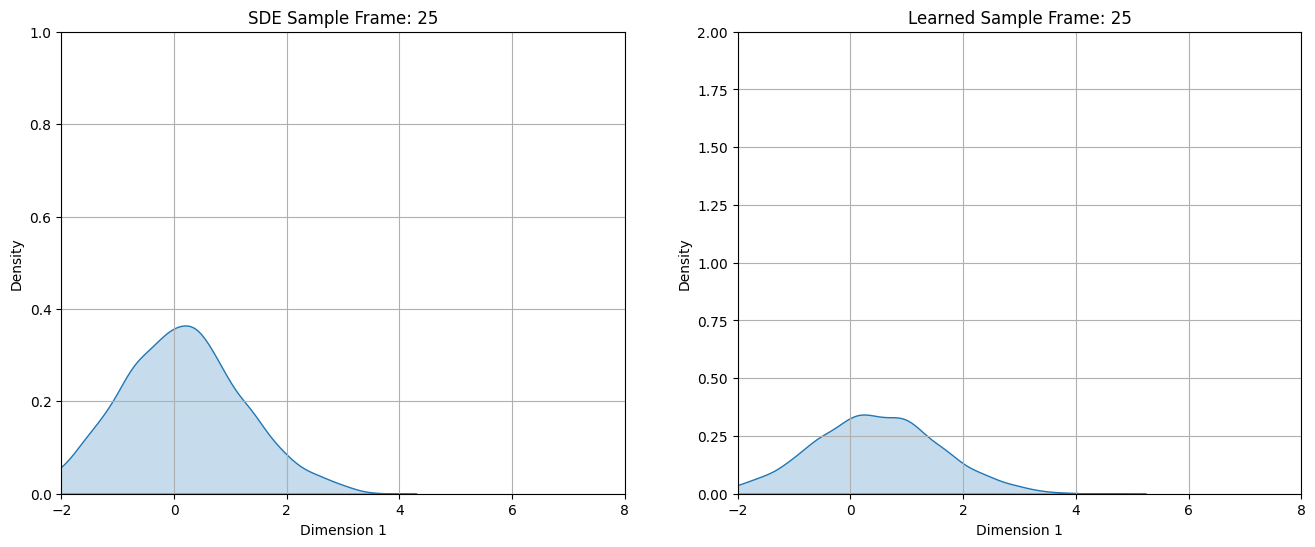

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import Image, display
from io import BytesIO
import seaborn as sns  # 确保导入 seaborn

# 将 JAX 数组转换为 NumPy 数组
all_samples_np = [np.array(sample) for sample in sde_samples]
learned_samples_np = [np.array(sample) for sample in learned_samples]

N = len(learned_samples)
# N = 51
# 只选择前8个样本创建 GIF
selected_sde_samples = all_samples_np[:N]
selected_learned_samples = learned_samples_np[:N]

# 创建一个内存中的虚拟文件 (使用 BytesIO)
gif_io = BytesIO()

with imageio.get_writer(gif_io, format='gif', mode='I', duration=100) as writer:
    for index, (sde_sample, learned_sample) in enumerate(zip(selected_sde_samples, selected_learned_samples)):
        # 创建图形并捕获为 PNG
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 创建两个子图
        
        # 绘制第一个样本
        sns.kdeplot(sde_sample.squeeze(), fill=True, ax=ax1)
        ax1.set_xlim(-2, 8)
        ax1.set_ylim(0, 1)
        ax1.set(title=f'SDE Sample Frame: {index + 1}', xlabel='Dimension 1', ylabel='Density')
        ax1.grid(True)
        
        # 绘制第二个样本
        sns.kdeplot(learned_sample.squeeze(), fill=True, ax=ax2)
        ax2.set_xlim(-2, 8)
        ax2.set_ylim(0, 2)
        ax2.set(title=f'Learned Sample Frame: {index + 1}', xlabel='Dimension 1', ylabel='Density')
        ax2.grid(True)
        
        # 保存到 BytesIO 对象
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        
        # 读取 PNG 图像数据并添加到 GIF
        image = imageio.imread(buf)
        writer.append_data(image)

# 重置 GIF BytesIO 的文件指针
gif_io.seek(0)

# 显示 GIF
display(Image(data=gif_io.read(), format='gif'))

In [5]:
N = len(learned_samples)
# N = 51
print(N)

201


In [6]:
import numpy as np
from scipy.stats import levy_stable 
# N = 51

# 参数初始化
LAMBDA = 30
D = 2  # 扩散系数
dt = 1e-3  # 时间步长
num_steps = (N-1)*5 + 1  # 时间步数
num_samples = 4000  # 样本数量

# 创建初始样本
x0 = np.random.normal(0, 1, (num_samples, 1))

# 初始化样本数组，只保存每25步的数据
step_save = 5
saved_steps = num_steps // step_save + 1
sdeLevy = np.zeros((num_samples, saved_steps))
print(sdeLevy.shape)
# # 模拟每个样本路径
for i in range(num_samples):
    x_brown = x0[i,0]
    x_levy = x0[i,0]
    save_index = 0
    for t in range(num_steps):
        if t % step_save == 0:
            sdeLevy[i, save_index] = x_levy
            save_index += 1

        dW = np.random.normal(0, 1)  # 增量Wiener过程
        # dx_brown = (1 - x_brown) * dt + np.sqrt(D) * np.sqrt(2 * dt) * dW
        # dx_brown = (x_brown - x_brown**3) * dt + np.sqrt(D) * np.sqrt(2 * dt) * dW
        # NN = np.random.poisson(LAMBDA * dt)
        # # Y = np.random.uniform(0, 1, NN)
        # Y =0
        # Y = np.random.normal(loc = 0.1, scale=(1/24)**1, size = NN)
        # sum_Y = np.sum(Y)
        # x_brown += dx_brown 

        dx_levy = (1 - x_levy) * dt + np.sqrt(D) * np.sqrt(2 * dt) * dW
        # dx_levy = (x_levy - x_levy**3) * dt + np.sqrt(D) * np.sqrt(2 * dt) * dW
        NN = np.random.poisson(LAMBDA * dt)
        # Y = np.random.uniform(0, 1, NN)
        Y = 0
        Y = np.random.normal(loc = 0.1, scale=(2/48)**1, size = NN)
        sum_Y = np.sum(Y)
        x_levy = x_levy + dx_levy + sum_Y

(4000, 201)


/tmp/ipykernel_877810/934633385.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Point")


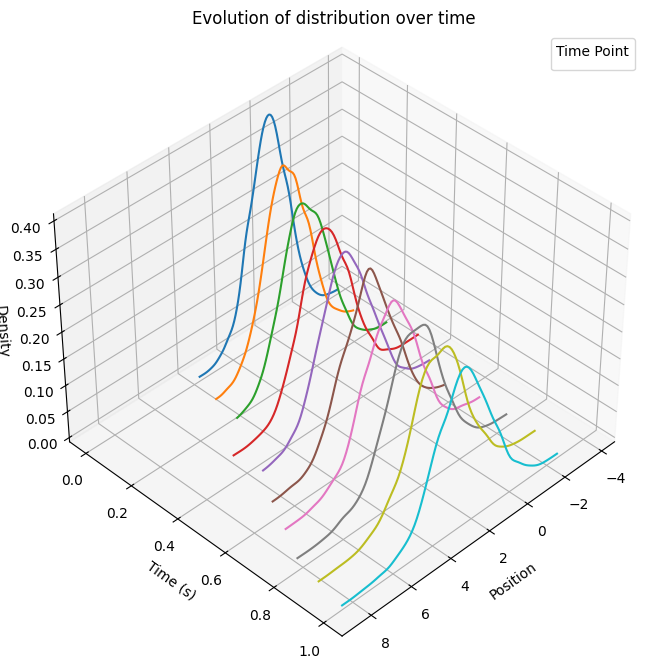

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
def estimate_density(data_slice):
    kde = gaussian_kde(data_slice)
    x_range = np.linspace(data_slice.min(), data_slice.max(), 100)
    density = kde(x_range)
    return x_range, density

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 为了避免图过于密集，我们可以只选取一部分时间点进行绘制
time_indices = np.linspace(0, 200, 10, dtype=int)  # 从 201 个时间点中选取 20 个时间点进行绘制

for t in time_indices:
    x, density = estimate_density(sdeLevy[:, t])
    ax.plot(x, density, zs=t*0.005, zdir='y')

# 设置视角
elevation = 40  # 设置仰角为  度
azimuth = 45   # 设置方位角为  度
ax.view_init(elev=elevation, azim=azimuth)

ax.set_xlabel('Position')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density')
ax.legend(title="Time Point")
plt.title('Evolution of distribution over time')
plt.show()

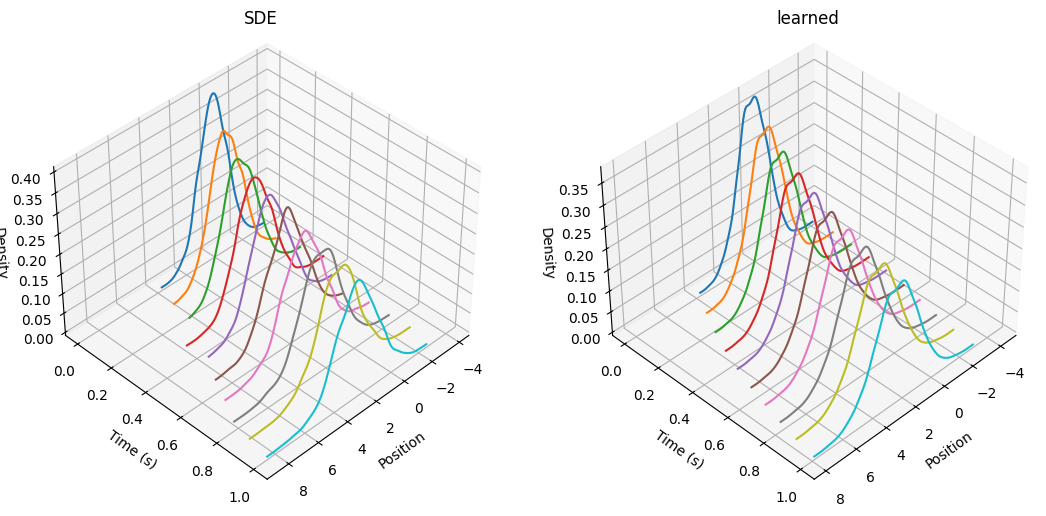

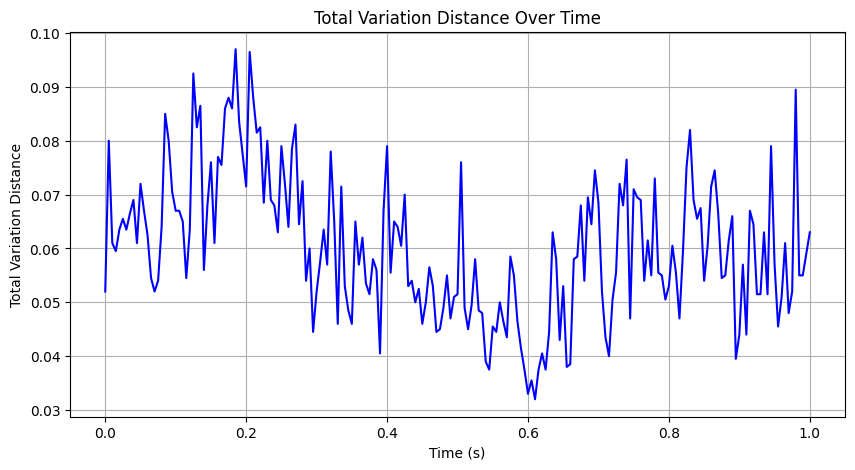

: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm

def estimate_density(data_slice):
    kde = gaussian_kde(data_slice)
    x_range = np.linspace(data_slice.min(), data_slice.max(), 100)
    density = kde(x_range)
    return x_range, density

def calculate_histogram(data, bins):
    hist, _ = np.histogram(data, bins=bins, density=True)
    hist = hist / hist.sum()
    return hist

def total_variation(hist1, hist2):
    # 计算两个直方图之间的 Total Variation 距离
    # print(hist1.sum(),hist2.sum())
    return np.sum(np.abs(hist1 - hist2)) 

fig = plt.figure(figsize=(20, 6))
time_indices = np.linspace(0, 200, 10, dtype=int)

# 第一子图
ax1 = fig.add_subplot(131, projection='3d')
for t in time_indices:
    x, density = estimate_density(sdeLevy[:, t])
    ax1.plot(x, density, zs=t*0.005, zdir='y')
ax1.set_title('SDE')
ax1.set_xlabel('Position')
ax1.set_ylabel('Time (s)')
ax1.set_zlabel('Density')
ax1.view_init(elev=40, azim=45)

# 第二子图
ax2 = fig.add_subplot(132, projection='3d')
for t in time_indices:
    x, density = estimate_density(learned_samples_np[t].squeeze())
    ax2.plot(x, density, zs=t*0.005, zdir='y')
ax2.set_title('learned')
ax2.set_xlabel('Position')
ax2.set_ylabel('Time (s)')
ax2.set_zlabel('Density')
ax2.view_init(elev=40, azim=45)

# 第三子图
tv_errors = []
time_indices = np.linspace(0, 200, 200, dtype=int)
for t in time_indices:
    bins = np.linspace(min(sdeLevy[:, t].min(), learned_samples_np[t].min()), 
                       max(sdeLevy[:, t].max(), learned_samples_np[t].max()), 20)
    hist1 = calculate_histogram(sdeLevy[:, t], bins)
    hist2 = calculate_histogram(learned_samples_np[t].squeeze(), bins)
    tv_error = total_variation(hist1, hist2)
    tv_errors.append(tv_error)

# 创建折线图
plt.figure(figsize=(10, 5))
plt.plot(time_indices*0.005, tv_errors, linestyle='-', color='b')
plt.title('Total Variation Distance Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Total Variation Distance')
plt.grid(True)
plt.show()

In [9]:
# num_samples = 100000
# sdeLevy = np.zeros((num_samples, saved_steps))
# x0 = np.random.normal(0, 1, (num_samples, 1))

# # 预先计算所有随机变量
# dWs = np.random.normal(0, 1, (num_samples, num_steps, 1)) * np.sqrt(dt)
# NNs = np.zeros((num_samples, num_steps), dtype=int)

# # 遍历每一时间步
# for t in range(num_steps):
#     if t % step_save == 0:
#         sdeLevy[:, t // step_save] = np.squeeze(x0)
#     NNs[:, t] = np.random.poisson(LAMBDA * dt)
#     # print(NNs[:,t].shape)
#     dL = np.zeros((num_samples,1))
#     for i in range(num_samples):
#         if NNs[i, t] > 0:
#             Y = np.random.normal(0.1, (2/48)**1, NNs[i, t])
#             dL[i] = Y.sum()
    
#     x0 += (1- x0) * dt + np.sqrt(2 * D) * dWs[:, t] + dL

# # 最终步骤的保存
# sdeLevy[:, -1] = np.squeeze(x0)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import Image, display
from io import BytesIO
import seaborn as sns  # 确保导入 seaborn

# # 创建一个内存中的虚拟文件 (使用 BytesIO)
# gif_io = BytesIO()

# with imageio.get_writer(gif_io, format='gif', mode='I', duration=100) as writer:
#     for t in range(saved_steps):
#         # 创建图形并捕获为 PNG
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 创建两个子图
        
#         # 绘制第一个样本
#         sns.kdeplot(sdeBrownian[:, t], fill=True, ax=ax1)
#         ax1.set_xlim(-2, 8)
#         ax1.set_ylim(0, 2)
#         ax1.set(title=f'sdeBrownian: {t + 1}', xlabel='Dimension 1', ylabel='Density')
#         ax1.grid(True)
        
#         # 绘制第二个样本
#         sns.kdeplot(sdeLevy[:, t], fill=True, ax=ax2)
#         ax2.set_xlim(-2, 8)
#         ax2.set_ylim(0, 2)
#         ax2.set(title=f'sdeLevy: {t + 1}', xlabel='Dimension 1', ylabel='Density')
#         ax2.grid(True)
        
#         # 保存到 BytesIO 对象
#         buf = BytesIO()
#         plt.savefig(buf, format='png')
#         plt.close(fig)
#         buf.seek(0)
        
#         # 读取 PNG 图像数据并添加到 GIF
#         image = imageio.imread(buf)
#         writer.append_data(image)

# # 重置 GIF BytesIO 的文件指针
# gif_io.seek(0)

# # 显示 GIF
# display(Image(data=gif_io.read(), format='gif'))

In [11]:
# # saved_steps = 11  # Assuming we want the first 8 for a quick demo
# # Create a BytesIO stream for the GIF
# gif_io = BytesIO()

# with imageio.get_writer(gif_io, format='gif', mode='I', duration=50) as writer:
#     for t in range(saved_steps):
#         # Create a figure with a 2x2 grid of axes
#         fig, axs = plt.subplots(2, 2, figsize=(8, 8))
        
        
#         # Plot each sample type in its own subplot
#         sns.kdeplot(all_samples_np[t].squeeze(), fill=True, ax=axs[0, 0])
#         axs[0, 0].set(title=f'SDE Sample Frame: {t + 1}')
#         axs[0, 0].set_xlim(-2, 8)
#         axs[0, 0].set_ylim(0, 1)
#         axs[0, 0].grid(True)

#         sns.kdeplot(learned_samples_np[t].squeeze(), fill=True, ax=axs[0, 1])
#         axs[0, 1].set(title=f'Learned Sample Frame: {t + 1}')
#         axs[0, 1].set_xlim(-2, 8)
#         axs[0, 1].set_ylim(0, 1)
#         axs[0, 1].grid(True)
        
#         # Assume additional similar data for the other two plots
#         sns.kdeplot(sdeBrownian[:, t], fill=True, ax=axs[1, 0])
#         axs[1, 0].set(title=f'sdeBrownian: {t + 1}')
#         axs[1, 0].set_xlim(-2, 8)
#         axs[1, 0].set_ylim(0, 2)
#         axs[1, 0].grid(True)

#         sns.kdeplot(sdeLevy[:, t], fill=True, ax=axs[1, 1])
#         axs[1, 1].set(title=f'sdeLevy: {t + 1}')
#         axs[1, 1].set_xlim(-2, 8)
#         axs[1, 1].set_ylim(0, 2)
#         axs[1, 1].grid(True)

#         # Save to buffer
#         buf = BytesIO()
#         plt.savefig(buf, format='png')
#         plt.close(fig)
#         buf.seek(0)
        
#         # Read PNG image data and add to GIF
#         image = imageio.imread(buf)
#         writer.append_data(image)

# # Reset GIF BytesIO's file pointer
# gif_io.seek(0)

# # Display the GIF in Jupyter Notebook
# display(Image(data=gif_io.read(), format='gif'))

In [12]:
sdeLevy.shape

(4000, 201)

KeyboardInterrupt: 

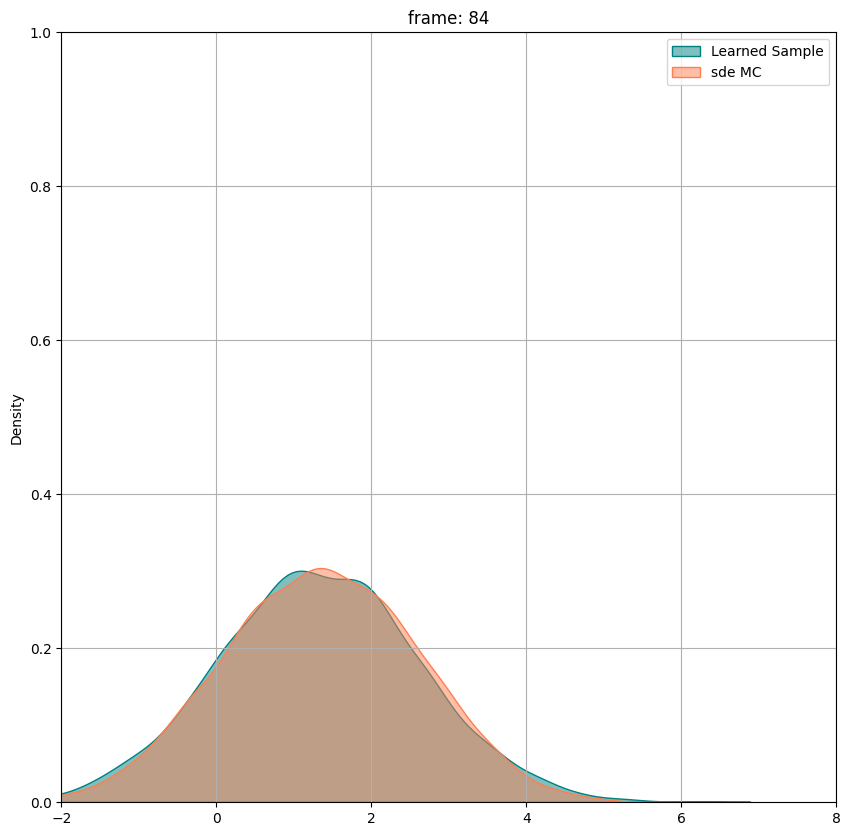

In [13]:
# saved_steps = 201
# Create a BytesIO stream for the GIF
gif_io = BytesIO()

with imageio.get_writer(gif_io, format='gif', mode='I', duration=50) as writer:
    for t in range(saved_steps):
        # Create a figure with a 2x2 grid of axes
        fig, axs = plt.subplots(figsize=(10, 10))
        

        # Plotting with specified colors
        sns.kdeplot(learned_samples_np[t].squeeze(), fill=True, ax=axs, label='Learned Sample', color='#008080', alpha=0.5)  # Teal
        sns.kdeplot(sdeLevy[:, t], fill=True, ax=axs, label='sde MC', color='#FF7F50', alpha=0.5)  # Coral
        # sns.kdeplot(sdeBrownian[:, t], fill=True, ax=axs, label='original', alpha=0.5)  # Coral
        axs.set(title=f'frame: {t + 1}')
        axs.set_xlim(-2, 8)
        axs.set_ylim(0, 1)
        axs.grid(True)
        axs.legend()  # Show legend

        # Save to buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        
        # Read PNG image data and add to GIF
        image = imageio.imread(buf)
        writer.append_data(image)

# Reset GIF BytesIO's file pointer
gif_io.seek(0)

# Display the GIF in Jupyter Notebook
display(Image(data=gif_io.read(), format='gif'))

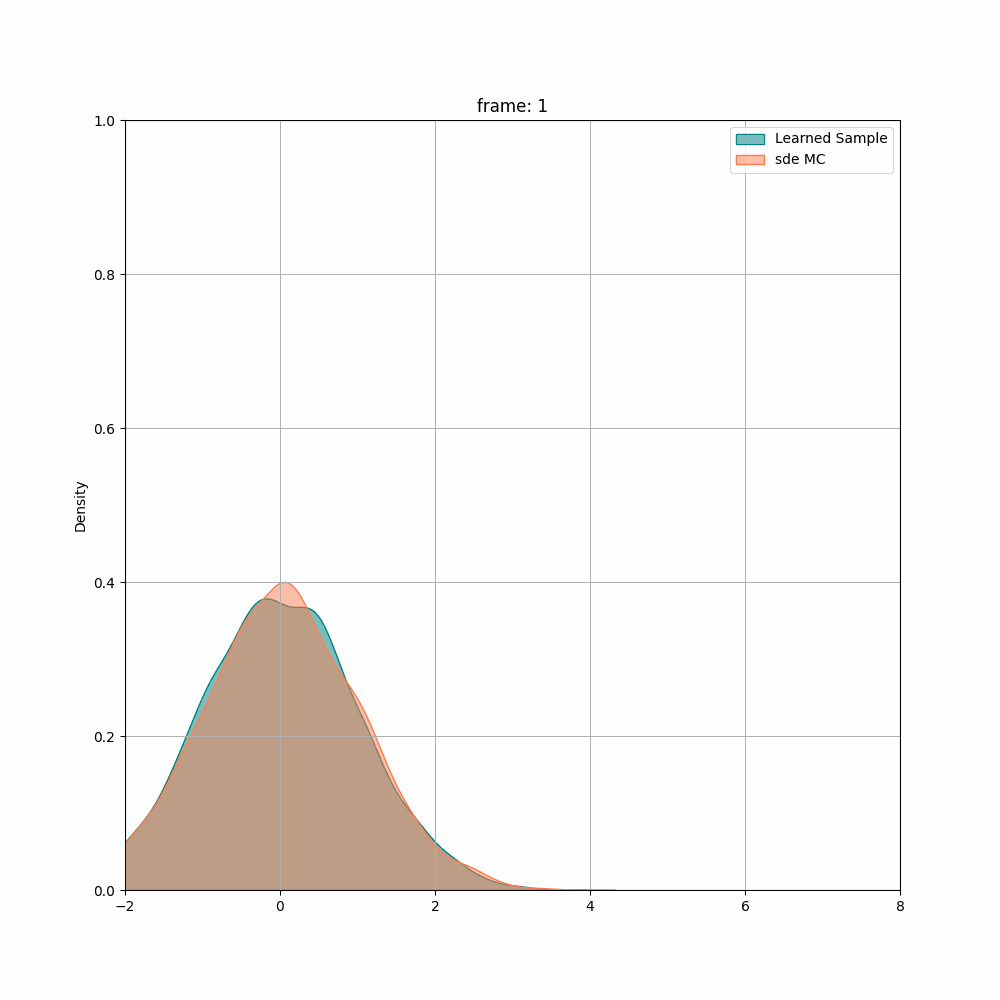

In [21]:
# Reset GIF BytesIO's file pointer
gif_io.seek(0)

# Display the GIF in Jupyter Notebook
display(Image(data=gif_io.read(), format='gif'))